In [ ]:
import pandas as pd
import os
from dotenv import load_dotenv
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from data_prep.topic_modeling.process_articles import *

In [ ]:
# define constants 
NTT_PATH = "./data/ntt_data/{}.csv"
COVID_PATH = "./data/covid_data/{}.csv"
WEATHER_PATH = "./data/weather/{}.csv"
NEWS_PATH = "./data/news/{}.csv"

In [ ]:
articles = load_articles()
articles.head()


In [ ]:
cov_articles = filter_kansenshasuu_articles(articles)
cov_articles['date'] = pd.to_datetime(cov_articles['date'])
cov_articles = pd.DataFrame(cov_articles.groupby('date')['num_publications_reporting'].first())
cov_articles

In [ ]:
shibs_df = pd.read_csv(NTT_PATH.format("shibuya_station_1_refined_binned"))
shibs_daytime = shibs_df[shibs_df["time_bin"] == "800-1700"].reset_index(drop=True)
shibs_daytime["population_log"] = shibs_daytime["population"].apply(math.log)
shibs_daytime["date"] = pd.to_datetime(shibs_daytime["date"])
shibs_daytime

In [ ]:
shibs_daytime = shibs_daytime.merge(cov_articles, how="left", on="date")
shibs_daytime["num_publications_reporting"] = shibs_daytime["num_publications_reporting"].fillna(0).apply(int)
shibs_daytime

In [ ]:
shibs_daytime.columns

In [ ]:
# set date as index
shibs_daytime.set_index('date', inplace=True)

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# create lag variables
shibs_daytime['population_lag'] = shibs_daytime['population'].shift(1)
shibs_daytime['population_log_lag'] = shibs_daytime['population_log'].shift(1)
shibs_daytime['total_new_cases_lag'] = shibs_daytime['total_new_cases'].shift(1)
shibs_daytime['tokyo_new_cases_lag'] = shibs_daytime['tokyo_new_cases'].shift(1)
shibs_daytime['tokyo_new_cases_week_lag'] = shibs_daytime['tokyo_new_cases'].shift(7)
shibs_daytime['total_weekly_diff_lag'] = shibs_daytime['total_weekly_diff'].shift(1)
shibs_daytime['tokyo_weekly_diff_lag'] = shibs_daytime['tokyo_weekly_diff'].shift(1)
shibs_daytime['total_severe_cases_lag'] = shibs_daytime['total_severe_cases'].shift(1)
shibs_daytime['tokyo_severe_cases_lag'] = shibs_daytime['tokyo_severe_cases'].shift(1)
shibs_daytime['total_cum_deaths_lag'] = shibs_daytime['total_cum_deaths'].shift(1)
shibs_daytime['tokyo_cum_deaths_lag'] = shibs_daytime['tokyo_cum_deaths'].shift(1)
shibs_daytime['total_daily_deaths_lag'] = shibs_daytime['total_daily_deaths'].shift(1)
shibs_daytime['tokyo_daily_deaths_lag'] = shibs_daytime['tokyo_daily_deaths'].shift(1)

mask = ['population', 'population_lag', 'population_log', 'population_log_lag', 
        'total_new_cases_lag', 'holiday', 'tokyo_new_cases_lag', 'total_weekly_diff_lag', 
        'tokyo_weekly_diff_lag', 'tokyo_new_cases_week_lag']

# add weather dummies
mask += list(shibs_daytime.columns[shibs_daytime.columns.str.contains(r"weather_\d+")])

# add soe dummies
mask += list(shibs_daytime.columns[shibs_daytime.columns.str.contains(r"soe\d+")])

# add wave dummies
mask += list(shibs_daytime.columns[shibs_daytime.columns.str.contains(r"wave\d+")])

# add weekday dummies
mask += list(shibs_daytime.columns[shibs_daytime.columns.str.contains(r"weekday_\d+")])

print(mask) 

# prepare data for linear regression
reg_df = shibs_daytime[mask]

reg_df = reg_df.dropna(axis=0)

# REMOVED FOLLOWING DUE TO NA VALUES 
    # 'total_severe_cases_lag',
    # 'tokyo_severe_cases_lag',
    # 'total_cum_deaths_lag',
    # 'tokyo_cum_deaths_lag',
    # 'total_daily_deaths_lag', 
    # 'tokyo_daily_deaths_lag',

In [ ]:
reg_df

In [ ]:
# add urgency score to reg_df 
# create urgency dummy
cov_articles["urgency"] = cov_articles["num_publications_reporting"].apply(lambda x: int(x>=3))

reg_df1 = reg_df.merge(cov_articles, how="left", on="date")
reg_df1['urgency'] = reg_df1['urgency'].fillna(0).apply(int)
reg_df1['num_publications_reporting'] = reg_df1['num_publications_reporting'].fillna(0).apply(int)
reg_df1

In [ ]:
reg_df1 = reg_df1.dropna(axis=0)
reg_df1

In [ ]:
# select the columns to use as features and target
# start with unlogged values
X = reg_df1.drop(['population_log', 'population_log_lag', 'population'], axis=1)
y = reg_df1['population']
X

In [ ]:
import statsmodels.api as sm

# add constant to the model
X = sm.add_constant(X)

# fit the model
model = sm.OLS(y, X).fit()

# summary of the model
print(model.summary())

In [ ]:
# get rid of urgency, total new cases, total_ weekly_diff, tokyo_weekly_diff
X = reg_df1.drop(['population_log', 'population_log_lag', 'population', 'urgency', 'total_new_cases_lag', 'total_weekly_diff_lag', 'tokyo_weekly_diff_lag'], axis=1)
y = reg_df1['population']
X

In [ ]:
# add constant to the model
X = sm.add_constant(X)

# fit the model
model = sm.OLS(y, X).fit()

# summary of the model
print(model.summary())

In [ ]:
# now do the same but with logged variables 
# get rid of urgency, total new cases, total_ weekly_diff, tokyo_weekly_diff
X = reg_df1.drop(['population', 'population_lag', 'population_log', 'urgency', 'total_new_cases_lag', 'total_weekly_diff_lag', 'tokyo_weekly_diff_lag'], axis=1)
y = reg_df1['population_log']
X

In [ ]:
# add constant to the model
X = sm.add_constant(X)

# fit the model
model = sm.OLS(y, X).fit()

# summary of the model
print(model.summary())

In [32]:
def perform_regression(filename: str, time_bin: str):
    # read articles into dataframe 
    cov_articles = filter_kansenshasuu_articles(articles)
    cov_articles['date'] = pd.to_datetime(cov_articles['date'])
    cov_articles = pd.DataFrame(cov_articles.groupby('date')['num_publications_reporting'].first())

    # read ntt data
    df = pd.read_csv(NTT_PATH.format(filename))
    # set time_bin
    daytime = df[df["time_bin"] == time_bin].reset_index(drop=True)
    # add population_log 
    daytime["population_log"] = daytime["population"].apply(math.log)
    # convert date to datetime 
    daytime["date"] = pd.to_datetime(daytime["date"])
    # merge ntt and articles df 
    daytime = daytime.merge(cov_articles, how="left", on="date")
    daytime["num_publications_reporting"] = daytime["num_publications_reporting"].fillna(0).apply(int)
    # set date as index
    daytime.set_index('date', inplace=True)
    # create lag variables
    daytime['population_lag'] = daytime['population'].shift(1)
    daytime['population_log_lag'] = daytime['population_log'].shift(1)
    daytime['tokyo_new_cases_lag'] = daytime['tokyo_new_cases'].shift(1)
    daytime['tokyo_new_cases_week_lag'] = daytime['tokyo_new_cases'].shift(7)
    
    # get regression data 
    mask = ['population', 'population_lag', 'population_log', 'population_log_lag', 
            'holiday', 'tokyo_new_cases_lag', 'tokyo_new_cases_week_lag']

    # add weather dummies
    mask += list(daytime.columns[daytime.columns.str.contains(r"weather_\d+")])

    # add soe dummies
    mask += list(daytime.columns[daytime.columns.str.contains(r"soe\d+")])

    # add wave dummies
    mask += list(daytime.columns[daytime.columns.str.contains(r"wave\d+")])

    # add weekday dummies
    mask += list(daytime.columns[daytime.columns.str.contains(r"weekday_\d+")])

    print(mask) 

    # prepare data for linear regression
    reg_df = daytime[mask]

    reg_df = reg_df.dropna(axis=0)

    # add urgency score to reg_df 
    # create urgency dummy
    cov_articles["urgency"] = cov_articles["num_publications_reporting"].apply(lambda x: int(x>=3))

    reg_df1 = reg_df.merge(cov_articles, how="left", on="date")
    reg_df1['urgency'] = reg_df1['urgency'].fillna(0).apply(int)
    reg_df1['num_publications_reporting'] = reg_df1['num_publications_reporting'].fillna(0).apply(int)
    
    reg_df1 = reg_df1.dropna(axis=0)

    # get rid of urgency, total new cases, total_ weekly_diff, tokyo_weekly_diff
    X = reg_df1.drop(['population_log', 'population_log_lag', 'population', 'urgency'], axis=1)
    y = reg_df1['population']
    
    # add constant to the model
    X = sm.add_constant(X)

    # fit the model
    model = sm.OLS(y, X).fit()

    # summary of the model
    print(model.summary())

    # now do the same but with logged variables 
    # get rid of urgency, total new cases, total_ weekly_diff, tokyo_weekly_diff
    X = reg_df1.drop(['population', 'population_lag', 'population_log', 'urgency'], axis=1)
    y = reg_df1['population_log']
    
    # add constant to the model
    X = sm.add_constant(X)

    # fit the model
    model_log = sm.OLS(y, X).fit()

    # summary of the model
    print(model_log.summary())

    reg_df2 = reg_df.merge(cov_articles, how="left", on="date")
    reg_df2['urgency'] = reg_df2['urgency'].fillna(0).apply(int)
    reg_df2['num_publications_reporting'] = reg_df2['num_publications_reporting'].fillna(0).apply(int)
    
    reg_df2 = reg_df2.dropna(axis=0)

    # Create interaction columns for each interaction between a wave and num_publications_reporting
    for wave in ['wave1', 'wave2', 'wave3', 'wave4', 'wave5']:
        reg_df2[f"{wave}_x_num_publications_reporting"] = reg_df2[wave] * reg_df2["num_publications_reporting"]

    # get rid of urgency, total new cases, total_ weekly_diff, tokyo_weekly_diff
    X = reg_df2.drop(['population', 'population_lag', 'population_log', 'urgency'], axis=1)
    y = reg_df2['population_log']

    # add constant to the model
    X = sm.add_constant(X)

    # fit the model
    model_interactions = sm.OLS(y, X).fit()

    # summary of the model
    print(model_interactions.summary())



    return (model, model_log, model_interactions)



In [33]:
perform_regression('shibuya_station_1_refined_binned', '800-1700')

['population', 'population_lag', 'population_log', 'population_log_lag', 'holiday', 'tokyo_new_cases_lag', 'tokyo_new_cases_week_lag', 'weather_1', 'weather_2', 'weather_3', 'weather_4', 'weather_9', 'weather_10', 'weather_15', 'soe1', 'soe2', 'soe3', 'soe4', 'semi-soe1', 'semi-soe2', 'wave1', 'wave2', 'wave3', 'wave4', 'wave5', 'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6']
                            OLS Regression Results                            
Dep. Variable:             population   R-squared:                       0.910
Model:                            OLS   Adj. R-squared:                  0.907
Method:                 Least Squares   F-statistic:                     266.7
Date:                Mon, 30 Jan 2023   Prob (F-statistic):               0.00
Time:                        17:24:06   Log-Likelihood:                -7614.1
No. Observations:                 709   AIC:                         1.528e+04
Df Residuals:            

(<statsmodels.regression.linear_model.RegressionResultsWrapper at 0x288b9f9d0>,
 <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x288b39ba0>)

In [34]:
perform_regression('tokyo_ootemachi_refined_binned', '800-1700')

['population', 'population_lag', 'population_log', 'population_log_lag', 'holiday', 'tokyo_new_cases_lag', 'tokyo_new_cases_week_lag', 'weather_1', 'weather_2', 'weather_3', 'weather_4', 'weather_9', 'weather_10', 'weather_15', 'soe1', 'soe2', 'soe3', 'soe4', 'semi-soe1', 'semi-soe2', 'wave1', 'wave2', 'wave3', 'wave4', 'wave5', 'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6']
                            OLS Regression Results                            
Dep. Variable:             population   R-squared:                       0.900
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     235.7
Date:                Mon, 30 Jan 2023   Prob (F-statistic):          3.14e-320
Time:                        17:25:10   Log-Likelihood:                -8141.6
No. Observations:                 709   AIC:                         1.634e+04
Df Residuals:            

(<statsmodels.regression.linear_model.RegressionResultsWrapper at 0x288b9f5e0>,
 <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x288c00280>)

In [35]:
perform_regression('mitaka_refined_binned', '800-1700')

['population', 'population_lag', 'population_log', 'population_log_lag', 'holiday', 'tokyo_new_cases_lag', 'tokyo_new_cases_week_lag', 'weather_1', 'weather_2', 'weather_3', 'weather_4', 'weather_9', 'weather_10', 'weather_15', 'soe1', 'soe2', 'soe3', 'soe4', 'semi-soe1', 'semi-soe2', 'wave1', 'wave2', 'wave3', 'wave4', 'wave5', 'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6']
                            OLS Regression Results                            
Dep. Variable:             population   R-squared:                       0.870
Model:                            OLS   Adj. R-squared:                  0.865
Method:                 Least Squares   F-statistic:                     175.3
Date:                Mon, 30 Jan 2023   Prob (F-statistic):          1.36e-281
Time:                        17:25:29   Log-Likelihood:                -5804.7
No. Observations:                 709   AIC:                         1.166e+04
Df Residuals:            

(<statsmodels.regression.linear_model.RegressionResultsWrapper at 0x288bf7fa0>,
 <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x288c26290>)

/var/folders/00/2zkqvc3n5y37rp1f1p9qc_5r0000gn/T/ipykernel_75262/3728364571.py:13: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


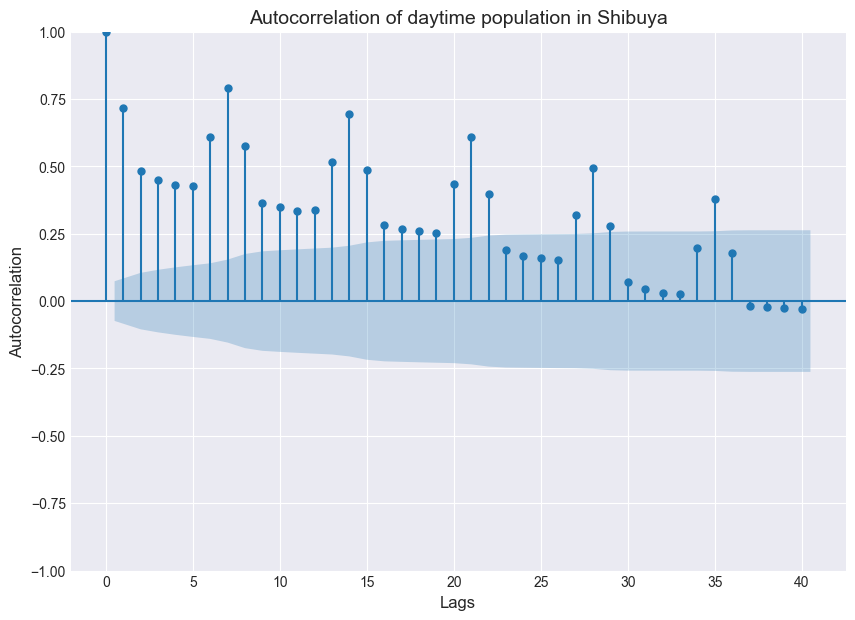

In [36]:
################################
## VISUALIZING AUTOCORRELATION IN DATA 
################################

# Import pandas
import pandas as pd

# reg_df

# Import matplotlib and set the style
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-darkgrid')

# Import plot_acf from statsmodels
from statsmodels.graphics.tsaplots import plot_acf

plt.rc("figure", figsize=(10, 7))
# Plot ACF of population_log for past 40 lags
plot_acf(reg_df.population_log, lags=40)
plt.xlabel('Lags', fontsize=12)
plt.ylabel('Autocorrelation', fontsize=12)
plt.title('Autocorrelation of daytime population in Shibuya', fontsize=14)
plt.show()